# LSST Colour Determination

Real Solar System objects have colours. The LSST will observe across a full _ugrizy_ wavelength range. You therefore probably want to include some colours in your model populations. The purpose of this notebook is to walk you through the steps of how you can take an existing optical reflectance spectra of your desired class of object and convert it into colours in the LSST bandpass system. This notebook relies on the user having installed rubin_sim to work. Instructions on this can be found at: https://rubin-sim.lsst.io/installation.html

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

import seaborn as sns
sns.set_context('talk')

In [4]:
# define a straight line function for later fitting
def lin(x, m, c): 
    return m*x + c

We use the LSST filter throughputs that are included within the rubin_sim data download.

In [5]:
# read in the LSST filter throughputs from rubin_sim
lsst = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    lsst[f] = phot_utils.Bandpass()
    lsst[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))

wavelen_min = lsst['g'].wavelen.min()
wavelen_max = lsst['g'].wavelen.max()

First, let's read in the original spectrum data and plot the optical section within the LSST wavelength range (300-1150nm). \
(The data used in this notebook of 2002 PN34 is originally from DeMeo et al., 2010 https://doi.org/10.1051/0004-6361/201014042)

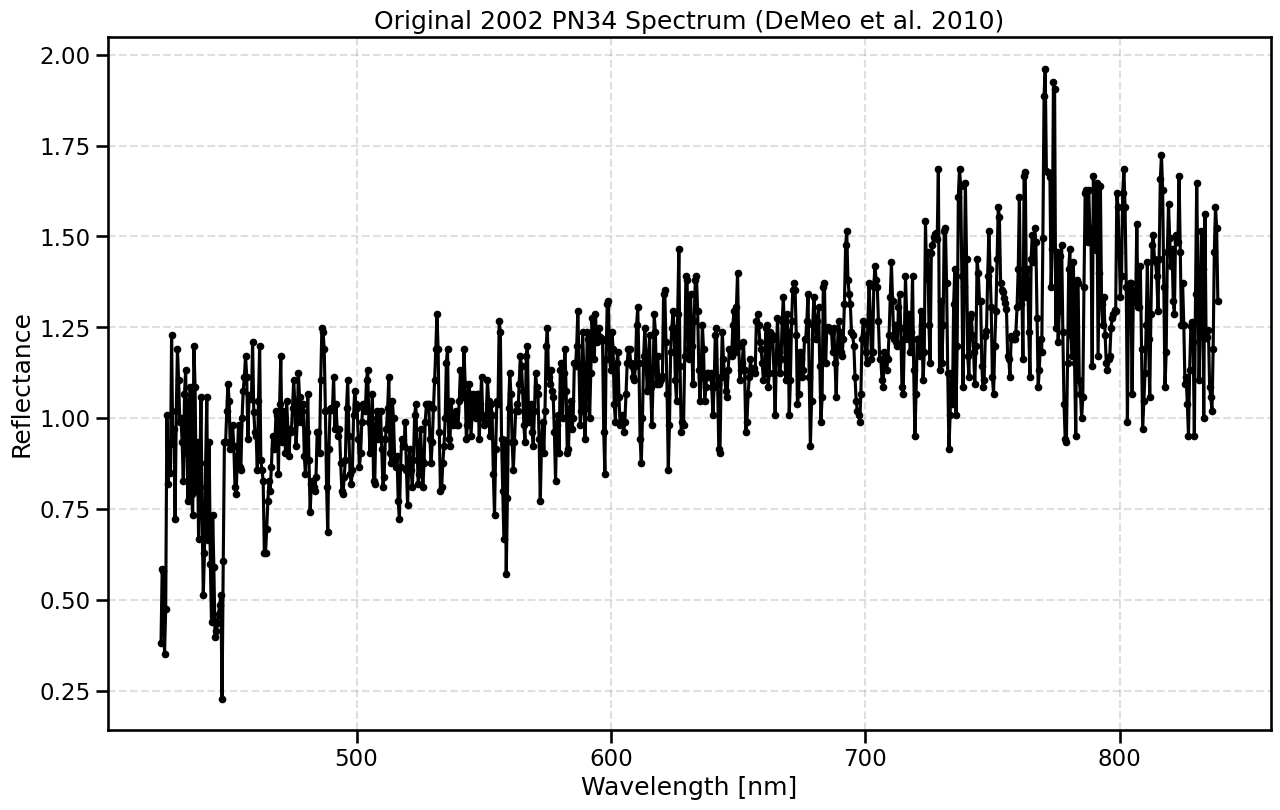

In [11]:
tno = pd.read_table('./2002PN34_highres.spec', sep=r'\s+', names=['wavelen','reflectance'])
tno.wavelen = tno.wavelen * 1000
tno = tno[tno.wavelen < 1300] # <- cut off the spectrum that expands into NIR
ogtno = tno 

fig = plt.figure(figsize=(15,9))
plt.plot(tno.wavelen, tno.reflectance, marker='.', color='k', zorder=10)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.title(r'Original 2002 PN34 Spectrum (DeMeo et al. 2010)')
plt.grid(True, alpha=0.4, linestyle='dashed')

plt.show()

This original optical data only exists in the wavelength range of ~400-850nm. We want to estimate what all of the _ugrizy_ colours will be within LSST however, so let's extrapolate the data to the full LSST wavelength range. We can do this by estimating the slopes at both red and blue ends and extrapolating straight lines from there to the LSST wavelength limits (here we assume no change in slopes in this unkown region). Be warned that due to this extrapolation, any magnitudes and colours calculated later must be treated with caution, and not taken as conclusive measurements.

In [44]:
# normalise to 550nm by fitting a spline to the data and finding the value of reflectance at 550nm
norm_window = np.where((tno.wavelen > 450) & (tno.wavelen < 650))
spl = UnivariateSpline(tno.wavelen.loc[norm_window], tno.reflectance.loc[norm_window])
spl.set_smoothing_factor(0.01)

xs = np.linspace(450, 650, 201)
idx = np.where((xs > 549.999) & (xs < 550.001))
norm_flux = spl(xs)[idx]

tno.reflectance = tno.reflectance / norm_flux


# extrapolate blue end
bluest = tno.wavelen.min()
condition = ((tno.wavelen > bluest) & (tno.wavelen < bluest+100)) # <- define the range of the blue end of spectrum that we will derive a slope from

popt, pcov = curve_fit(lin, tno.wavelen[condition], tno.reflectance[condition])
wavelen_extend_b = np.arange(wavelen_min, bluest+1.0, 1) # <- +1.0 just to ensure we cover into the existing blue end of spectrum
reflect_extend_b = lin(wavelen_extend_b, popt[0], popt[1])


# extrapolate red end
reddest = tno.wavelen.max()
condition = (tno.wavelen > 700) # <- define the range of the red end of spectrum that we will derive a slope from
 
popt, pcov = curve_fit(lin, tno.wavelen[condition], tno.reflectance[condition])
wavelen_extend_r = np.arange(750, wavelen_max+1.0, 1) # <- +1.0 just to ensure we cover into the existing red end of spectrum
reflect_extend_r = lin(wavelen_extend_r, popt[0], popt[1])

Also, as this is an optical TNO spectrum, we don't need to be too concerned with the individual features. Instead, we care more about the spectral gradient here, so let's also smooth out the data to remove any noisier data points, and bundle all of these new spectrum points into one.

In [45]:
# smooth out og spectrum
condition = (tno.wavelen > bluest) & (tno.wavelen < 750)
popt, pcov = curve_fit(lin, tno.wavelen[condition], tno.reflectance[condition])
smooth_ogwavelen = np.arange(bluest, 750, 1)
smooth_ogreflec = lin(smooth_ogwavelen, popt[0], popt[1])


# concatenate the extrapolated blue, red, and smoothed og spectra into one continuous spectrum for SED conversion
wavelen_final = np.concatenate([wavelen_extend_b, smooth_ogwavelen, wavelen_extend_r])
reflect_final = np.concatenate([reflect_extend_b, smooth_ogreflec, reflect_extend_r])
df = pd.DataFrame({'wavelen':wavelen_final, 'reflect':reflect_final}).sort_values(by=['wavelen']) # <- temporarily convert to dataframe so that we can resort the data properly by wavelength range so it is continuous
wavelen_final = df['wavelen'].values
reflect_final = df['reflect'].values

Let's look at what we have done to the spectrum so far then:

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/var/folders/gs/s705glmj5kv24l80j282mw1w0000gp/T/ipykernel_6214/3295509925.py:18: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel('$\lambda$ [nm]')


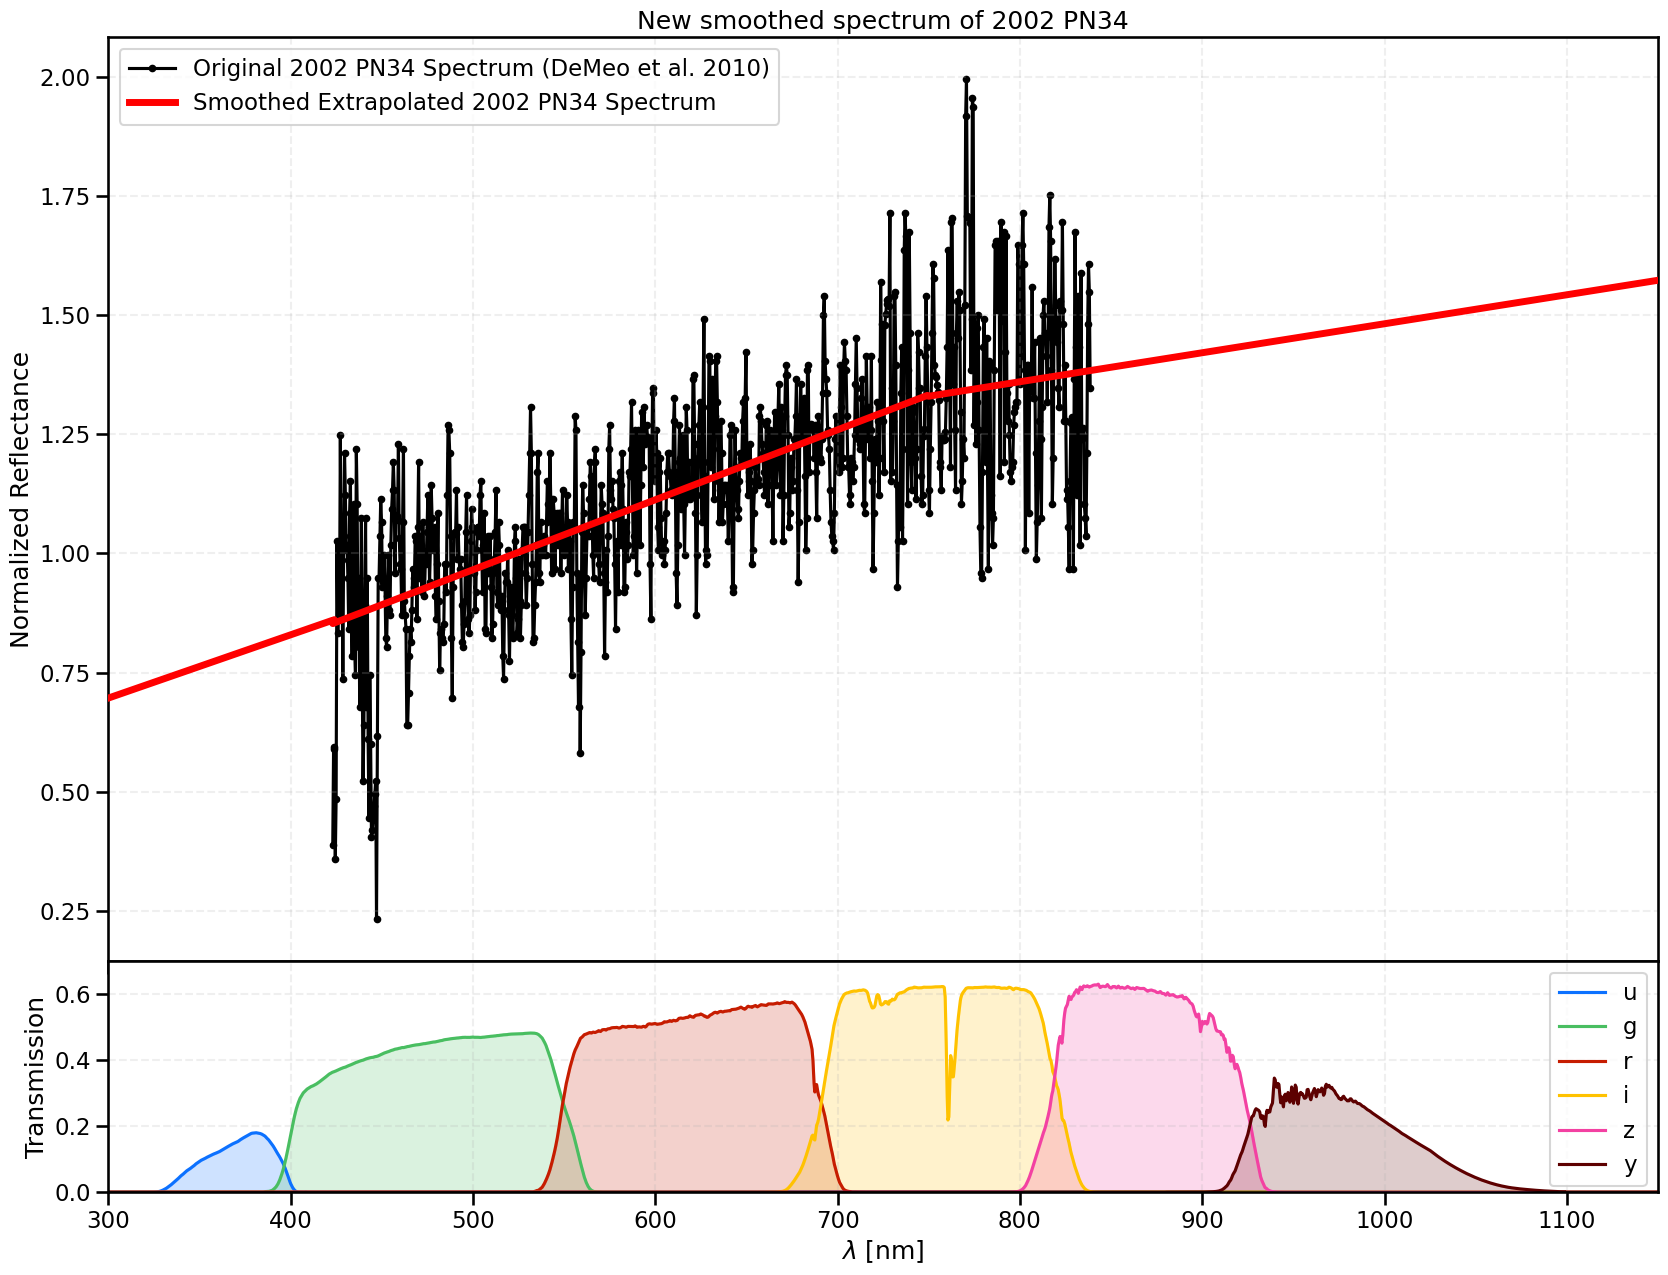

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(20,15), sharex=True, gridspec_kw={'height_ratios':[2,0.5]})
fig.subplots_adjust(hspace=0)

axs[0].plot(ogtno.wavelen, ogtno.reflectance, marker='.', color='k', zorder=1, label=r'Original 2002 PN34 Spectrum (DeMeo et al. 2010)')
axs[0].plot(wavelen_final, reflect_final, lw=5, color='red', zorder=10, alpha=1.0, label=r'Smoothed Extrapolated 2002 PN34 Spectrum')

axs[0].grid(True, alpha=0.2, linestyle='dashed')
axs[0].set_ylabel('Normalized Reflectance')
axs[0].set_title('New smoothed spectrum of 2002 PN34')
axs[0].legend(loc='upper left')

filtcols = ['#0c71ff', '#49be61', '#c61c00', '#ffc200', '#f341a2', '#5d0000'] # <- https://rtn-045.lsst.io/#colorblind-friendly-plots
for n, f in enumerate(lsst_filterlist):
    axs[1].plot(lsst[f].wavelen, lsst[f].sb, label=f, color=filtcols[n])
    axs[1].fill_between(lsst[f].wavelen, lsst[f].sb, alpha=0.2, color=filtcols[n])

axs[1].grid(True, alpha=0.2, linestyle='dashed')
axs[1].set_xlabel('$\lambda$ [nm]')
axs[1].set_ylabel('Transmission')
axs[1].set_ylim(0,0.7)
axs[1].set_xlim(wavelen_min, wavelen_max)
axs[1].legend()

plt.show()

We now have a good approximation for the slope of the spectrum across the entire _ugrizy_ range, and now we now want to convert this into a spectral energy distribution (SED) so that we can calculate our colours. Firstly, let's read in a Kurucz Solar spectrum from rubin_sim and multiply this back in to our reflectance spectrum. 

In [43]:
# set up SED object with smoothed wavelength and reflectance values
obj_sed = phot_utils.Sed()
obj_sed.set_sed(wavelen=wavelen_final, flambda=reflect_final)
og_obj_sed = obj_sed

# read in solar spectrum and match wavelength with object SED (for multiplying out sun)
sun = phot_utils.Sed()
sun.read_sed_flambda(os.path.join(get_data_dir(), 'movingObjects', 'kurucz_sun.gz'))
sun.resample_sed(wavelen_match=obj_sed.wavelen)

# turn reflectance spectra into SED
obj_sed = obj_sed.multiply_sed(sun, wavelen_step=0.1)

Let's see what this SED looks like then:

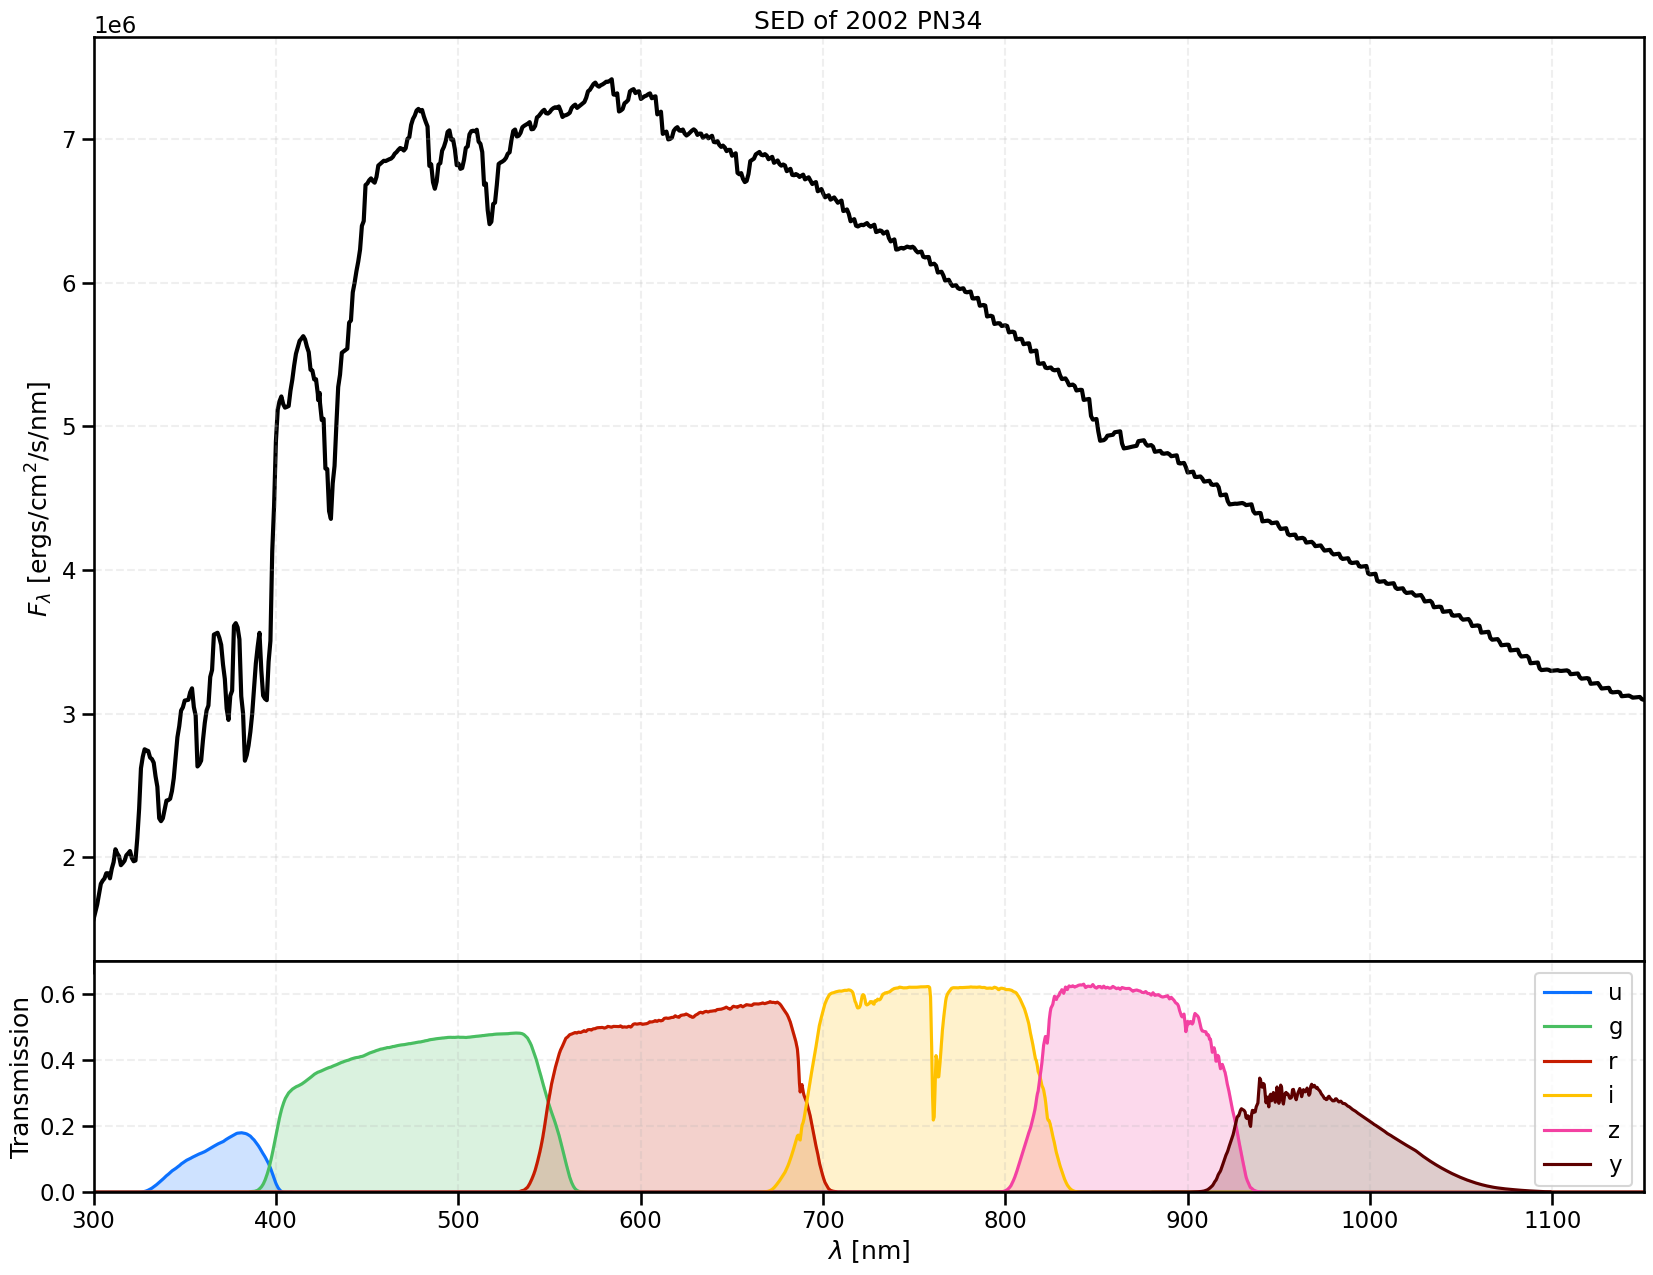

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(20,15), sharex=True, gridspec_kw={'height_ratios':[2,0.5]})
fig.subplots_adjust(hspace=0)

axs[0].plot(obj_sed.wavelen, obj_sed.flambda, lw=3, color='k', zorder=1, label=r'\huge Original 2002 PN34 Spectrum (DeMeo et al. 2010)')

axs[0].grid(True, alpha=0.2, linestyle='dashed')
axs[0].set_ylabel(r'$F_\lambda$ [ergs/cm$^2$/s/nm]')
axs[0].set_title('SED of 2002 PN34')

filtcols = ['#0c71ff', '#49be61', '#c61c00', '#ffc200', '#f341a2', '#5d0000'] # <- https://rtn-045.lsst.io/#colorblind-friendly-plots
for n, f in enumerate(lsst_filterlist):
    axs[1].plot(lsst[f].wavelen, lsst[f].sb, label=f, color=filtcols[n])
    axs[1].fill_between(lsst[f].wavelen, lsst[f].sb, alpha=0.2, color=filtcols[n])

axs[1].grid(True, alpha=0.2, linestyle='dashed')
axs[1].set_xlabel(r'$\lambda$ [nm]')
axs[1].set_ylabel('Transmission')
axs[1].set_ylim(0,0.7)
axs[1].set_xlim(wavelen_min, wavelen_max)
axs[1].legend()

plt.show()

The flux $F_b$ (in Janskys) under the bandpass $b$ can then be calculated as an integration of the SED flux density $F_\nu$ with response function $\phi_b$ as follows (see S2.6 of the LSST Science Book for more details https://arxiv.org/pdf/0912.0201):

$$
 F_b = \int_0^\infty F_\nu(\lambda) \phi_b(\lambda) d\lambda
$$

The exact actual implementation of this is done under the hood by rubin_sim, but essentially it is a simple np.trapz integration per filter. This is then converted into a magnitude using the standard conversion equation, and subsequently a colour is found.

In [19]:
# calculate magnitudes (in case user wants their own colours)
mags = {}
for f in lsst_filterlist:
    mags[f'LSST {f}'] = obj_sed.calc_mag(lsst[f])
mags = pd.DataFrame(mags, index=[0])

# calculate colours now (relative to LSST r)
colours = {}

refband = lsst['r']
refmag = obj_sed.calc_mag(refband)
for f in 'ugrizy':
    colours[f'LSST ({f}-r)'] = obj_sed.calc_mag(lsst[f]) - refmag
colours = pd.DataFrame(colours, index=[0])

colours.T

,0
LSST (u-r),1.983302
LSST (g-r),0.642863
LSST (r-r),0.000000
LSST (i-r),-0.267814
LSST (z-r),-0.342499
LSST (y-r),-0.400738


You may be interested in how accurate this method is for other filter systems for reference. The rubin_sim magnitude calculation method works for any other given filter response curves you may have. In the original De Meo et al., (2010) paper, they were able to measure $V$ ~ 20.7 and $R$ ~ 20.3 magnitudes, so let's see how the Johnson V-R colours we can calculate match up.

In [25]:
# read in the Johnson filter throughputs from rubin_sim
johnson = {}
johnson_filterlist = 'UBVR'
for f in johnson_filterlist:
    johnson[f] = phot_utils.Bandpass()
    johnson[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'johnson', f'johnson_{f}.dat'))
    johnson[f].resample_bandpass(wavelen_min=300, wavelen_max=1000)

# calculate colours in Johnson system for our object SED
refband = johnson['R']

refmag = obj_sed.calc_mag(refband)

for f in 'UBVR':
    colours[f'Johnson ({f}-R)'] = obj_sed.calc_mag(johnson[f]) - refmag

colours = pd.DataFrame(colours, index=[0])
print(f"we find (V-R) = {colours['Johnson (V-R)'].values[0]:.2f}")
print('from DeMeo et al. 2010, Table 3, (V-R) ~ 0.43')

we find (V-R) = 0.44
from DeMeo et al. 2010, Table 3, (V-R) ~ 0.43
